# Compare today's matter power spectra for PM, BullFrog 🐸 and COLA

Tristan Hoellinger<br/>
Institut d'Astrophysique de Paris</br>
tristan.hoellinger@iap.fr

In [1]:
from os.path import isfile
from pathlib import Path
import numpy as np

from pysbmy.power import PowerSpectrum
from pysbmy.fft import FourierGrid, read_FourierGrid
from pysbmy.field import read_field
from pysbmy.correlations import get_autocorrelation

## Setting up the environment

In [2]:
WORKDIR = "runs_params/"
SIMDIR = (
    "runs_sims/"  # need not be on same disk
)

``params.py`` contains the configuration for this notebook and can be adjusted.

In [3]:
from tools import generate_sim_params
# from tools import read_field
from params import (
    L0,
    L1,
    L2,
    corner0,
    corner1,
    corner2,
    N0,
    Np0,
    Npm0, Npm1, Npm2,
    cosmo,
    RedshiftLPT,
    RedshiftFCs,
    ai,
    af,
    cosmo_small_to_full_dict,
)

## Preparing the inputs

### Define the list of simulations to perform for this run

In [4]:
run_id = "run1"
force = False

# Parameters for the pm simulations
nsteps_pm_list = [200]  # , 30]

# Parameters for the cola simulations
nsteps_cola_list = [10, 20, 50]  # , 15]

# Parameters for the cola simulations
nsteps_bullfrog_list = [10, 20, 50]  # , 15]

In principle nothing needs to be changed below this cell.

In [5]:
wd = WORKDIR + run_id + "/"
simdir = SIMDIR + run_id + "/"
logdir = simdir + "logs/"
Path(wd).mkdir(parents=True, exist_ok=True)
Path(logdir).mkdir(parents=True, exist_ok=True)

nsim_pm = len(nsteps_pm_list)
nsim_cola = len(nsteps_cola_list)
nsim_bullfrog = len(nsteps_bullfrog_list)

ICs_path = simdir + "initial_density.h5"
simpath = simdir

In [6]:
# Path to the input matter power spectrum (generated later)
input_power_file = simdir + "input_power.h5"

### Generate the parameter files

The first preparatory step is to generate all the parameter files required for all the simulations.

To this end we use the `generate_sim_params` function defined in `params.py`.

In [7]:
common_params = {
    "Np0": Np0,
    "N0": N0,
    "L0": L0,
    "corner0": corner0,
    "corner1": corner1,
    "corner2": corner2,
    "h": cosmo["h"],
    "Omega_m": cosmo["Omega_m"],
    "Omega_b": cosmo["Omega_b"],
    "n_s": cosmo["n_s"],
    "sigma8": cosmo["sigma8"],
}

lpt_params = common_params.copy()
lpt_params["method"] = "lpt"
lpt_params["InputPowerSpectrum"] = input_power_file

pm_params = common_params.copy()
pm_params["method"] = "pm"
pm_params["TimeStepDistribution"] = 0
pm_params["ai"] = ai
pm_params["af"] = af
pm_params["RedshiftLPT"] = RedshiftLPT
pm_params["RedshiftFCs"] = RedshiftFCs
pm_params["Npm0"] = Npm0

cola_params = common_params.copy()
cola_params["method"] = "cola"
cola_params["TimeStepDistribution"] = 0
cola_params["ai"] = ai
cola_params["af"] = af
cola_params["RedshiftLPT"] = RedshiftLPT
cola_params["RedshiftFCs"] = RedshiftFCs
cola_params["Npm0"] = Npm0

bullfrog_params = common_params.copy()
bullfrog_params["method"] = "bullfrog"
bullfrog_params["TimeStepDistribution"] = 0
bullfrog_params["ai"] = ai
bullfrog_params["af"] = af
bullfrog_params["RedshiftLPT"] = RedshiftLPT
bullfrog_params["RedshiftFCs"] = RedshiftFCs
bullfrog_params["Npm0"] = Npm0

In [8]:
# generate_sim_params(lpt_params, ICs_path, wd, simdir, None, force)

# for i in range(nsim_pm):
#     print(f"PM nsteps = {nsteps_pm_list[i]}:")
#     pm_params["nsteps"] = nsteps_pm_list[i]
#     file_ext = f"nsteps{nsteps_pm_list[i]}"  # "pm" is already in the filename
#     generate_sim_params(pm_params, ICs_path, wd, simdir, file_ext, force)

# for i in range(nsim_cola):
#     print(f"COLA nsteps = {nsteps_cola_list[i]}:")
#     cola_params["nsteps"] = nsteps_cola_list[i]
#     file_ext = f"nsteps{nsteps_cola_list[i]}"  # "cola" is already in the filename
#     generate_sim_params(cola_params, ICs_path, wd, simdir, file_ext, force)

# for i in range(nsim_bullfrog):
#     print(f"BULLFROG nsteps = {nsteps_bullfrog_list[i]}:")
#     bullfrog_params["nsteps"] = nsteps_bullfrog_list[i]
#     file_ext = f"nsteps{nsteps_bullfrog_list[i]}"  # "bullfrog" is already in the filename
#     generate_sim_params(bullfrog_params, ICs_path, wd, simdir, file_ext, force)

### Generating the input power spectrum

The second preparatory step is to compute the initial power spectrum to be used in the simulations, given the cosmological parameters and prescription specified in ``params.py``. The power spectrum is saved in `input_power_file`.

In [9]:
# # If cosmo["WhichSpectrum"] == "class", then the module classy is
# # required.
# if not isfile(input_power_file):
#     Pk = PowerSpectrum(L0, L1, L2, N0, N0, N0, cosmo_small_to_full_dict(cosmo))
#     Pk.write(input_power_file)

In [10]:
# kmin = 0.0
# kmax = 1.0
# Nk = 64
# k_modes = np.linspace(kmin, kmax, Nk + 1)[:-1]
# input_ss_file = simdir + "input_ss_k_grid.h5"
# if not isfile(input_ss_file):
#     Gk = FourierGrid(L0, L1, L2, N0, N0, N0, k_modes=k_modes, kmax=kmax)
#     Gk.write(input_ss_file)

## Running the simulations

We are now ready to run the actual simulations using the Simbelmynë executable. Warning: the following may take some time, even in relatively low dimension, and should not be run on a login node.

In [11]:
# %%capture

# if not isfile(ICs_path) or not isfile(simdir + "lpt_density.h5") or not isfile(simdir + "lpt_particles.gadget3"):
#     !simbelmyne {wd}example_lpt.sbmy {logdir}lpt.txt

# for i in range(nsim_pm):
#     file_ext = f"nsteps{nsteps_pm_list[i]}"  # "pm" is already in the filename
#     if not isfile(simdir + f"{file_ext}_final_density_pm.h5"):
#         !simbelmyne {wd}{file_ext}_example_pm.sbmy {logdir}{file_ext}_pm.txt

# for i in range(nsim_cola):
#     file_ext = f"nsteps{nsteps_cola_list[i]}"  # "cola" is already in the filename
#     if not isfile(simdir + f"{file_ext}_final_density_cola.h5"):
#         !simbelmyne {wd}{file_ext}_example_cola.sbmy {logdir}{file_ext}_cola.txt

# for i in range(nsim_bullfrog):
#     file_ext = f"nsteps{nsteps_bullfrog_list[i]}"  # "bullfrog" is already in the filename
#     if not isfile(simdir + f"{file_ext}_final_density_bullfrog.h5"):
#         !simbelmyne {wd}{file_ext}_example_bullfrog.sbmy {logdir}{file_ext}_bullfrog.txt

The logs can be live-monitored in the corresponding files in the `logdir` directory.

## Results

In [12]:
from plot_utils import *

### Density fields

[13:57:13|STATUS    ]|Read field in data file 'runs_sims/run1/lpt_density.h5'...
[13:57:13|DIAGNOSTIC]==|ranges=[-125.0, 125.0, -125.0, 125.0, -125.0, 125.0, 128, 128, 128]
[13:57:13|STATUS    ]|Read field in data file 'runs_sims/run1/lpt_density.h5' done.
[13:57:13|STATUS    ]|Read field in data file 'runs_sims/run1/nsteps200_final_density_pm.h5'...
[13:57:13|DIAGNOSTIC]==|ranges=[-125.0, 125.0, -125.0, 125.0, -125.0, 125.0, 128, 128, 128]
[13:57:13|STATUS    ]|Read field in data file 'runs_sims/run1/nsteps200_final_density_pm.h5' done.
[13:57:13|STATUS    ]|Read field in data file 'runs_sims/run1/nsteps10_final_density_cola.h5'...
[13:57:13|DIAGNOSTIC]==|ranges=[-125.0, 125.0, -125.0, 125.0, -125.0, 125.0, 128, 128, 128]
[13:57:13|STATUS    ]|Read field in data file 'runs_sims/run1/nsteps10_final_density_cola.h5' done.
[13:57:13|STATUS    ]|Read field in data file 'runs_sims/run1/nsteps10_final_density_bullfrog.h5'...
[13:57:13|DIAGNOSTIC]==|ranges=[-125.0, 125.0, -125.0, 125.0, -125

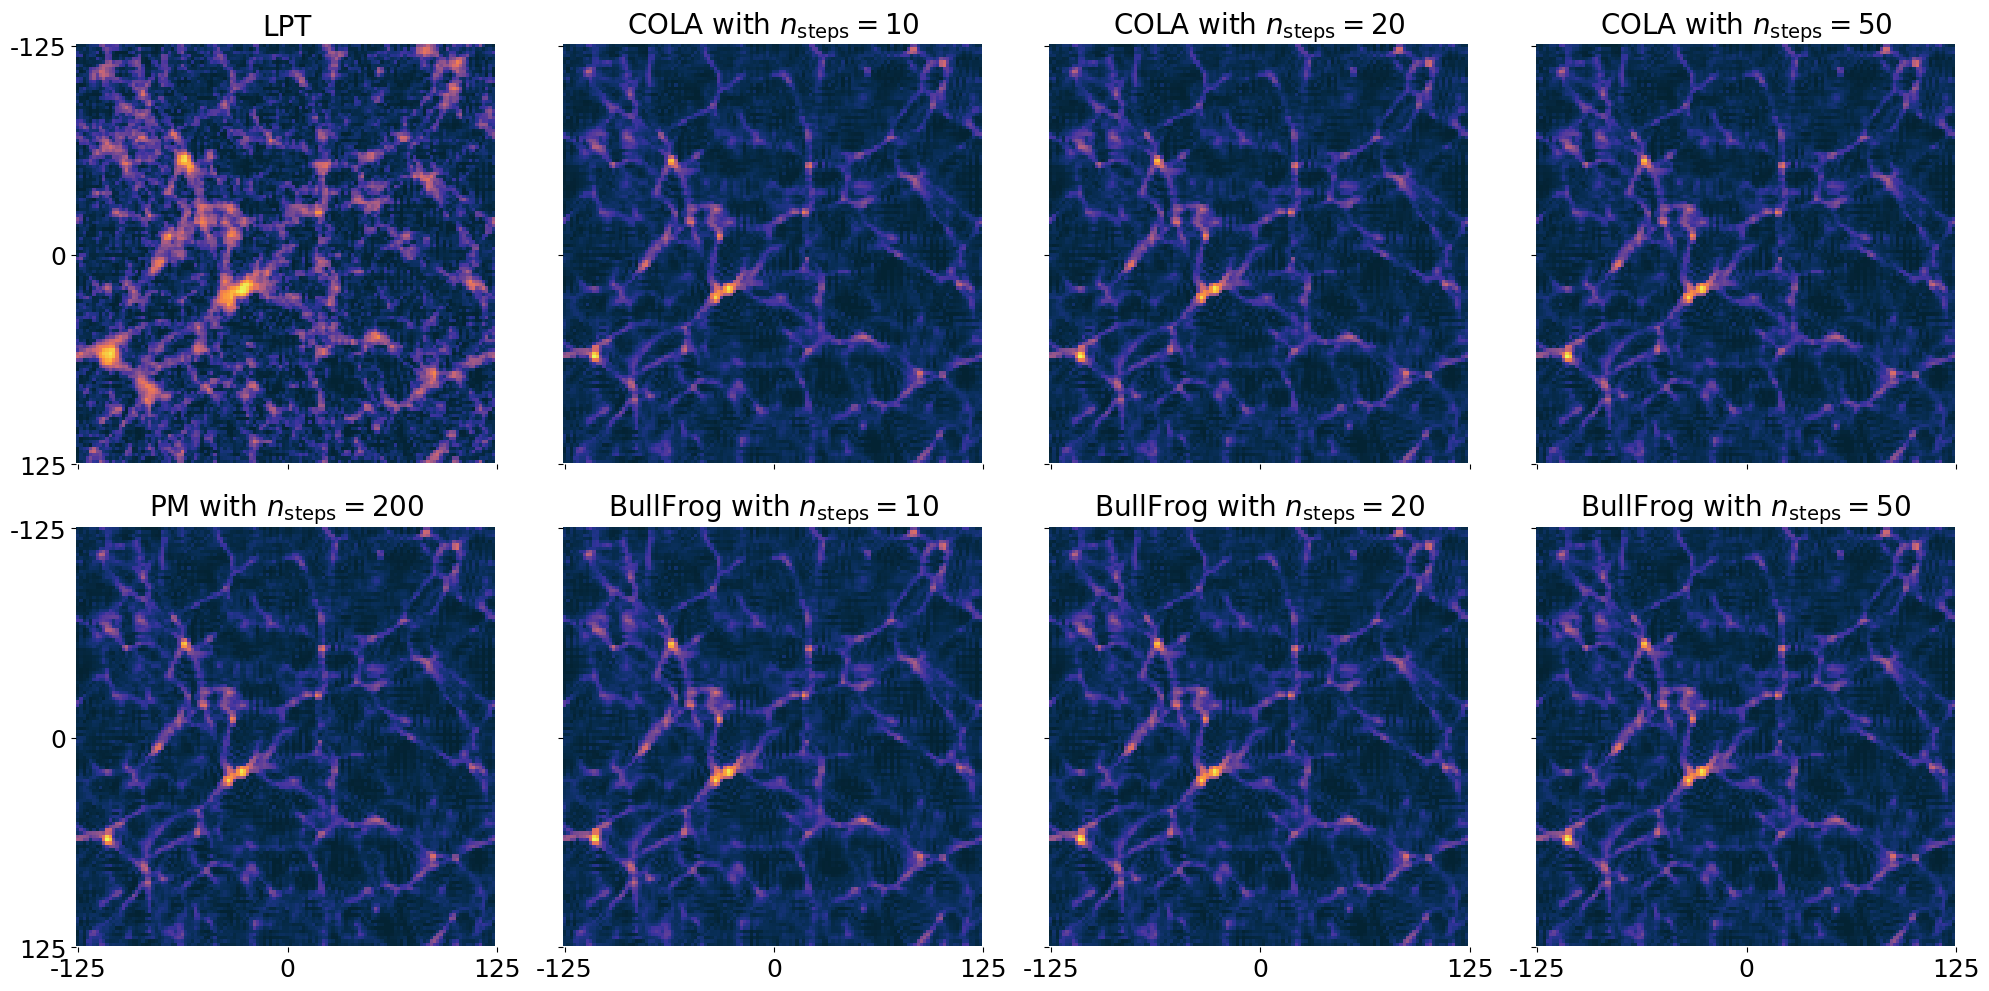

In [13]:
slice_ijk = (N0//2, slice(None), slice(None))
DELTA_LPT = read_field(simdir + "lpt_density.h5").data[slice_ijk]

all_nsteps = sorted(list(set(nsteps_cola_list + nsteps_bullfrog_list)))[:4]

ncols = len(all_nsteps) + 1
nrows = 2
fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols,5*nrows), sharex=True, sharey=True)
axs[0, 0].imshow(np.log(2 + DELTA_LPT), cmap=cmap)
axs[0, 0].set_title("LPT", fontsize=fs_titles)
DELTA_PM = read_field(simdir + f"nsteps{max(nsteps_pm_list)}_final_density_pm.h5").data[slice_ijk]
axs[1, 0].imshow(np.log(2 + DELTA_PM), cmap=cmap)
axs[1, 0].set_title(f"PM with $n_\\mathrm{{steps}}={max(nsteps_pm_list)}$", fontsize=fs_titles)
for i, nsteps in enumerate(all_nsteps):
    if nsteps in nsteps_cola_list:
        DELTA_COLA = read_field(simdir + f"nsteps{nsteps}_final_density_cola.h5").data[slice_ijk]
        axs[0,i+1].imshow(np.log(2+DELTA_COLA), cmap=cmap)
        axs[0, i + 1].set_title(f"COLA with $n_\\mathrm{{steps}}={nsteps}$", fontsize=fs_titles)
    if nsteps in nsteps_bullfrog_list:
        DELTA_BULLFROG = read_field(simdir + f"nsteps{nsteps}_final_density_bullfrog.h5").data[slice_ijk]
        axs[1, i + 1].imshow(np.log(2 + DELTA_BULLFROG), cmap=cmap)
        axs[1,i+1].set_title(f"BullFrog with $n_\\mathrm{{steps}}={nsteps}$", fontsize=fs_titles)
for ax in axs.flatten():
    ax.spines[["top", "right", "bottom", "left"]].set_visible(False)
for ax in axs[:,0]:
    ax.set_yticks([0, N0//2, N0])
    ax.set_yticklabels([f"{-L0/2:.0f}", "0", f"{L0/2:.0f}"], fontsize=fs)
for ax in axs[1,:]:
    ax.set_xticks([0, N0//2, N0])
    ax.set_xticklabels([f"{-L0/2:.0f}", "0", f"{L0/2:.0f}"], fontsize=fs)
for i in range(nrows):
    for j in range(ncols):
        if axs[i,j].get_title() == "":
            axs[i,j].axis("off")
plt.tight_layout()
plt.show()

### Computing and plotting final power spectra

In [14]:
G = read_FourierGrid(simdir + "input_ss_k_grid.h5")
k = G.k_modes[1:]
AliasingCorr = False

DELTA = read_field(simdir + "initial_density.h5")
Pk_INI, Vk_INI = get_autocorrelation(DELTA, G, False)
Pk_INI, Vk_INI = Pk_INI[1:], Vk_INI[1:]
Sk_INI = np.sqrt(Vk_INI)

DELTA = read_field(simdir + "lpt_density.h5")
Pk_LPT, Vk_LPT = get_autocorrelation(DELTA, G, AliasingCorr)
Pk_LPT, Vk_LPT = Pk_LPT[1:], Vk_LPT[1:]
Sk_LPT = np.sqrt(Vk_LPT)

Pk_PM_list = []
Sk_PM_list = []
for nsteps in nsteps_pm_list:
    DELTA = read_field(simdir + f"nsteps{nsteps}_final_density_pm.h5")
    Pk_PM, Vk_PM = get_autocorrelation(DELTA, G, AliasingCorr)
    Pk_PM, Vk_PM = Pk_PM[1:], Vk_PM[1:]
    Sk_PM = np.sqrt(Vk_PM)
    Pk_PM_list.append(Pk_PM)
    Sk_PM_list.append(Sk_PM)

Pk_ref = Pk_PM_list[-1]

Pk_COLA_list = []
Sk_COLA_list = []
for nsteps in nsteps_cola_list:
    DELTA = read_field(simdir + f"nsteps{nsteps}_final_density_cola.h5")
    Pk_COLA, Vk_COLA = get_autocorrelation(DELTA, G, AliasingCorr)
    Pk_COLA, Vk_COLA = Pk_COLA[1:], Vk_COLA[1:]
    Sk_COLA = np.sqrt(Vk_COLA)
    Pk_COLA_list.append(Pk_COLA)
    Sk_COLA_list.append(Sk_COLA)

Pk_BULLFROG_list = []
Sk_BULLFROG_list = []
for nsteps in nsteps_bullfrog_list:
    DELTA = read_field(simdir + f"nsteps{nsteps}_final_density_bullfrog.h5")
    Pk_BULLFROG, Vk_BULLFROG = get_autocorrelation(DELTA, G, AliasingCorr)
    Pk_BULLFROG, Vk_BULLFROG = Pk_BULLFROG[1:], Vk_BULLFROG[1:]
    Sk_BULLFROG = np.sqrt(Vk_BULLFROG)
    Pk_BULLFROG_list.append(Pk_BULLFROG)
    Sk_BULLFROG_list.append(Sk_BULLFROG)

[13:57:14|STATUS    ]|Read Fourier grid in data file 'runs_sims/run1/input_ss_k_grid.h5'...
[13:57:14|DIAGNOSTIC]==|L0=250.0, L1=250.0, L2=250.0
[13:57:14|DIAGNOSTIC]==|N0=128, N1=128, N2=128, N2_HC=65, N_HC=1064960, NUM_MODES=64
[13:57:14|STATUS    ]|Read Fourier grid in data file 'runs_sims/run1/input_ss_k_grid.h5' done.
[13:57:14|STATUS    ]|Read field in data file 'runs_sims/run1/initial_density.h5'...
[13:57:14|DIAGNOSTIC]==|ranges=[-125.0, 125.0, -125.0, 125.0, -125.0, 125.0, 128, 128, 128]
[13:57:14|STATUS    ]|Read field in data file 'runs_sims/run1/initial_density.h5' done.
[13:57:14|STATUS    ]|Getting auto-correlation in Fourier space (using 16 cores)...
[13:57:14|STATUS    ]|Getting auto-correlation in Fourier space (using 16 cores) done.
[13:57:14|STATUS    ]|Read field in data file 'runs_sims/run1/lpt_density.h5'...
[13:57:14|DIAGNOSTIC]==|ranges=[-125.0, 125.0, -125.0, 125.0, -125.0, 125.0, 128, 128, 128]
[13:57:14|STATUS    ]|Read field in data file 'runs_sims/run1/lpt_

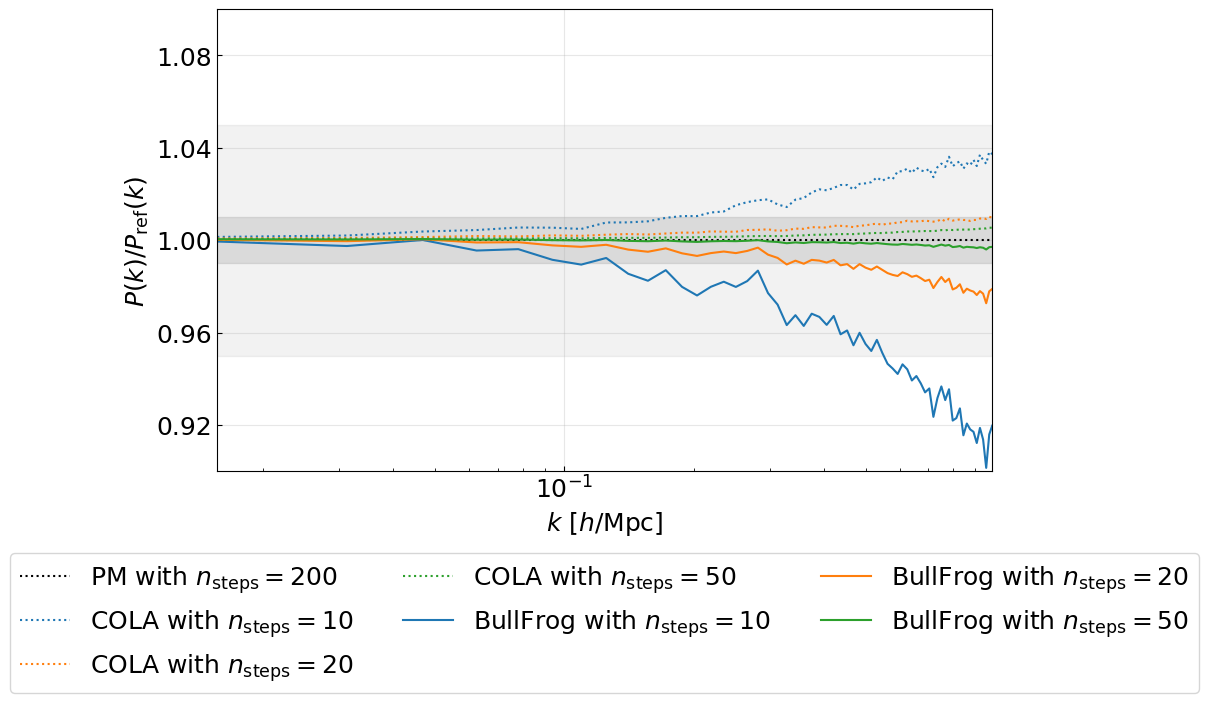

In [15]:
focused = True

common_nsteps = sorted(set(nsteps_cola_list).intersection(nsteps_bullfrog_list))
common_nsteps = [nsteps for nsteps in common_nsteps if nsteps > 2]
nlines = len(common_nsteps) + 2

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xscale("log")
k = G.k_modes[1:]
ax.set_xlim([k.min(), k.max()])
ax.set_ylim([0, 2])  # to be adjusted depending on the setup
ax.set_ylim([0.9, 1.1]) if focused else  ax.set_ylim([0, 2]) 

label_ref = f"PM with $n_\\mathrm{{steps}}={max(nsteps_pm_list)}$"
ax.plot([1e-3, 1e1], [1, 1], color="black", linestyle=":", label=label_ref)
# ax.plot(k, Pk_INI / Pk_ref, label="ICs", color=cols[len(common_nsteps)], linestyle="--")
# ax.plot(k, Pk_LPT / Pk_ref, label="LPT", color=cols[len(common_nsteps) + 1], linestyle="--")
for i, nsteps in enumerate(nsteps_pm_list[:-1]):
    ax.plot(
        k,
        Pk_PM_list[i] / Pk_ref,
        label=f"PM with $n_\\mathrm{{steps}}={nsteps}$",
        linestyle="--",
        color=cols[i],
    )
for i, nsteps in enumerate(common_nsteps):
    ax.plot(
        k,
        Pk_COLA_list[i] / Pk_ref,
        label=f"COLA with $n_\\mathrm{{steps}}={nsteps}$",
        linestyle=":",
        color=cols[i],
    )
for i, nsteps in enumerate(common_nsteps):
    ax.plot(
        k,
        Pk_BULLFROG_list[i] / Pk_ref,
        label=f"BullFrog with $n_\\mathrm{{steps}}={nsteps}$",
        linestyle="-",
        color=cols[i],
    )
bnd1 = 0.01 if focused else 0.1  # to be adjusted depending on the setup
bnd2 = 0.05 if focused else 0.2  # to be adjusted depending on the setup
ax.axhspan(1 - bnd1, 1 + bnd1, color="grey", alpha=0.2)
ax.axhspan(1 - bnd2, 1 + bnd2, color="grey", alpha=0.1)

ax.grid(alpha=0.3)
ax.yaxis.set_major_locator(plt.MaxNLocator(6))
ax.yaxis.get_major_ticks()[0].label1.set_visible(False)
ax.set_xlabel("$k$ [$h/\\mathrm{Mpc}$]", fontsize=fs)
ax.set_ylabel("$P(k)/P_\\mathrm{ref}(k)$", fontsize=fs)
ax.tick_params(which="both", direction="in")
ax.tick_params(axis="both", which="major", labelsize=fs)
ax.tick_params(axis="both", which="minor", labelsize=fs)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=fs)

plt.show()

[13:57:15|STATUS    ]|Read timestepping configuration in 'runs_params/run0/nsteps10_ts_bullfrog.h5'...
[13:57:15|STATUS    ]|Read timestepping configuration in 'runs_params/run0/nsteps10_ts_bullfrog.h5' done.


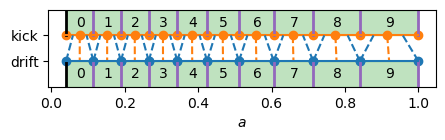

In [16]:
from pysbmy.timestepping import BullFrogTimeStepping

BullFrogTimeStepping.read("runs_params/run0/nsteps10_ts_bullfrog.h5").plot()

In [17]:
from scipy.stats import wasserstein_distance_nd

In [18]:
DELTA_BULLFROG = read_field(simdir + f"nsteps{nsteps_bullfrog_list[-1]}_final_density_bullfrog.h5")
DELTA_PM = read_field(simdir + f"nsteps{max(nsteps_pm_list)}_final_density_pm.h5")

[13:57:15|STATUS    ]|Read field in data file 'runs_sims/run1/nsteps50_final_density_bullfrog.h5'...
[13:57:15|DIAGNOSTIC]==|ranges=[-125.0, 125.0, -125.0, 125.0, -125.0, 125.0, 128, 128, 128]
[13:57:15|STATUS    ]|Read field in data file 'runs_sims/run1/nsteps50_final_density_bullfrog.h5' done.
[13:57:15|STATUS    ]|Read field in data file 'runs_sims/run1/nsteps200_final_density_pm.h5'...
[13:57:15|DIAGNOSTIC]==|ranges=[-125.0, 125.0, -125.0, 125.0, -125.0, 125.0, 128, 128, 128]
[13:57:15|STATUS    ]|Read field in data file 'runs_sims/run1/nsteps200_final_density_pm.h5' done.


In [19]:
DELTA_BULLFROG.data.size

2097152

In [20]:
positions=np.moveaxis(np.meshgrid(np.linspace(0.,L0,Npm0)+corner0,np.linspace(0.,L1,Npm1)+corner1,np.linspace(0.,L2,Npm2)+corner2,indexing='ij'),0,-1)

In [21]:
positions.shape

(128, 128, 128, 3)

In [22]:
ind=np.array(np.meshgrid(np.arange(Npm0),np.arange(Npm1),np.arange(Npm2)),).reshape(3,-1)

In [23]:
ind

array([[  0,   0,   0, ..., 127, 127, 127],
       [  0,   0,   0, ..., 127, 127, 127],
       [  0,   1,   2, ..., 125, 126, 127]])

In [24]:
positions[0,0,5]

array([-125.        , -125.        , -115.15748031])

In [25]:
positions[*ind].shape

(2097152, 3)

In [26]:
# wasserstein_distance_nd(positions[*ind],
#                         positions[*ind],
#                         np.log(2+DELTA_BULLFROG.data)[*ind],
#                         np.log(2+DELTA_PM.data)[*ind])

In [27]:
DELTA_BULLFROG = read_field(simdir + f"nsteps{nsteps_bullfrog_list[1]}_final_density_bullfrog.h5")
DELTA_COLA = read_field(simdir + f"nsteps{nsteps_cola_list[2]}_final_density_cola.h5")

[13:57:15|STATUS    ]|Read field in data file 'runs_sims/run1/nsteps20_final_density_bullfrog.h5'...
[13:57:15|DIAGNOSTIC]==|ranges=[-125.0, 125.0, -125.0, 125.0, -125.0, 125.0, 128, 128, 128]
[13:57:15|STATUS    ]|Read field in data file 'runs_sims/run1/nsteps20_final_density_bullfrog.h5' done.
[13:57:15|STATUS    ]|Read field in data file 'runs_sims/run1/nsteps50_final_density_cola.h5'...
[13:57:15|DIAGNOSTIC]==|ranges=[-125.0, 125.0, -125.0, 125.0, -125.0, 125.0, 128, 128, 128]
[13:57:15|STATUS    ]|Read field in data file 'runs_sims/run1/nsteps50_final_density_cola.h5' done.


In [43]:
def KL_divergence(DELTA_ref,DELTA):
    # convert deltas into densities
    P=np.clip((1+np.array(DELTA_ref.data)),1e-3,1e12)
    Q=np.clip((1+np.array(DELTA.data)),1e-3,1e12)
    assert P.shape == Q.shape, f"Different shapes of density fields: {P.shape} and {Q.shape}"
    
    # P=np.clip(np.log(2+DELTA_ref.data),1e-3,1e3)
    # Q=np.clip(np.log(2+DELTA.data),1e-3,1e3)
    
    sumP=np.sum(P)
    sumQ=np.sum(Q)
    return np.sum(P*np.log(P/Q))/sumP-np.log(sumP/sumQ)

In [41]:
DELTA_LPT = read_field(simdir + "lpt_density.h5")
DELTA_REF = read_field(simdir + f"nsteps{max(nsteps_pm_list)}_final_density_pm.h5")

Delta_dict={"lpt":DELTA_LPT,"ref":DELTA_REF}
for i, nsteps in enumerate(all_nsteps):
    if nsteps in nsteps_cola_list:
        Delta_dict[f"COLA{nsteps}"] = read_field(simdir + f"nsteps{nsteps}_final_density_cola.h5")
    if nsteps in nsteps_bullfrog_list:
        Delta_dict[f"BF{nsteps}"] = read_field(simdir + f"nsteps{nsteps}_final_density_bullfrog.h5")

[14:00:47|STATUS    ]|Read field in data file 'runs_sims/run1/lpt_density.h5'...
[14:00:47|DIAGNOSTIC]==|ranges=[-125.0, 125.0, -125.0, 125.0, -125.0, 125.0, 128, 128, 128]
[14:00:47|STATUS    ]|Read field in data file 'runs_sims/run1/lpt_density.h5' done.
[14:00:47|STATUS    ]|Read field in data file 'runs_sims/run1/nsteps200_final_density_pm.h5'...
[14:00:47|DIAGNOSTIC]==|ranges=[-125.0, 125.0, -125.0, 125.0, -125.0, 125.0, 128, 128, 128]
[14:00:47|STATUS    ]|Read field in data file 'runs_sims/run1/nsteps200_final_density_pm.h5' done.
[14:00:47|STATUS    ]|Read field in data file 'runs_sims/run1/nsteps10_final_density_cola.h5'...
[14:00:47|DIAGNOSTIC]==|ranges=[-125.0, 125.0, -125.0, 125.0, -125.0, 125.0, 128, 128, 128]
[14:00:47|STATUS    ]|Read field in data file 'runs_sims/run1/nsteps10_final_density_cola.h5' done.
[14:00:47|STATUS    ]|Read field in data file 'runs_sims/run1/nsteps10_final_density_bullfrog.h5'...
[14:00:47|DIAGNOSTIC]==|ranges=[-125.0, 125.0, -125.0, 125.0, -125

In [46]:
for key,value in Delta_dict.items():
    print(f"{key}: {KL_divergence(DELTA_REF,value)}")

lpt: 0.23120437562465668
ref: 0.0
COLA10: 0.0044063483364880085
BF10: 0.036066677421331406
COLA20: 0.0003911798121407628
BF20: 0.0034609148278832436
COLA50: 1.5261332009686157e-05
BF50: 0.00011150421050842851


Text(0.5, 0.98, 'Kullback–Leibler divergence of the density field with respect to a reference density field (PM200)')

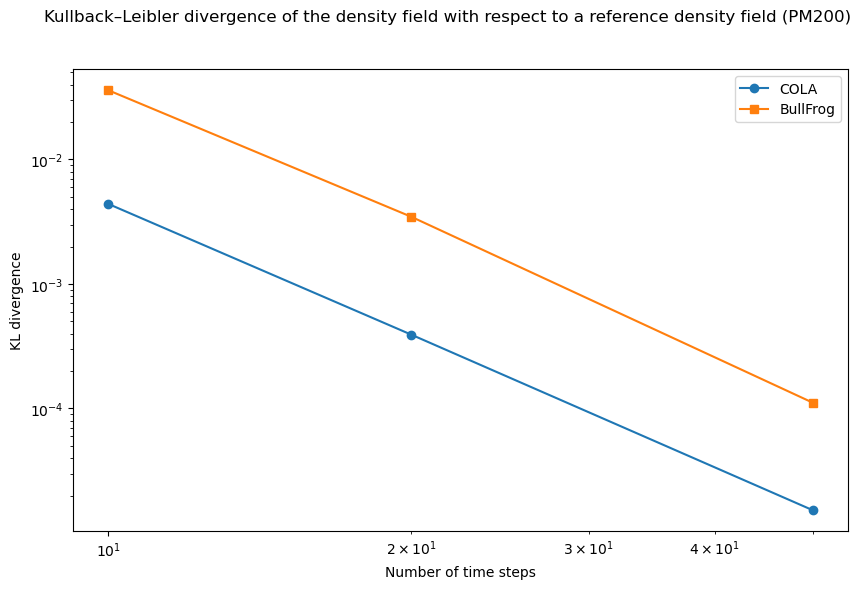

In [50]:
fig,ax=plt.subplots(figsize=(10, 6))

ax.plot(nsteps_cola_list,[KL_divergence(DELTA_REF,Delta_dict[f"COLA{n}"]) for n in nsteps_cola_list],label="COLA",marker='o')
ax.plot(nsteps_bullfrog_list,[KL_divergence(DELTA_REF,Delta_dict[f"BF{n}"]) for n in nsteps_bullfrog_list],label="BullFrog",marker='s')
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()
ax.set_xlabel("Number of time steps")
ax.set_ylabel("KL divergence")
fig.suptitle("Kullback–Leibler divergence of the density field with respect to a reference density field (PM200)")

In [31]:
np.log(2+DELTA_BULLFROG.data).max()

6.0716166

In [32]:
DELTA_BULLFROG.data[*ind].shape

(2097152,)

In [33]:
DELTA_BULLFROG.L0

250.0